In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
sns.set()

### Using term frequency of n-grams across tv shows (with pre-defined vocabulary)

In [2]:
client = bigquery.Client()

query=f"""
select *
from goldenfleece.final_task.tv_1grams_monthly
order by DATE
"""
document_df = client.query(query).to_dataframe()
document_df.head(3)

,DATE,NGRAM,COUNT
0,2009-07-01,ha,2.760000
1,2009-07-01,no,26.370614
2,2009-07-01,ass,1.500000


In [3]:
document_df = document_df.astype({"DATE":"datetime64"}) 
document_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781379 entries, 0 to 781378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   DATE    781379 non-null  datetime64[ns]
 1   NGRAM   781379 non-null  object        
 2   COUNT   781379 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 60.6 MB


In [4]:
document_df.DATE.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  781379
unique                    138
top       2016-06-01 00:00:00
freq                     6023
first     2009-07-01 00:00:00
last      2020-12-01 00:00:00
Name: DATE, dtype: object

In [5]:
tf_df = pd.pivot_table(document_df, values="COUNT", index="DATE", columns="NGRAM", aggfunc=np.mean, fill_value=0)

In [6]:
tf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2009-07-01 to 2020-12-01
Columns: 7247 entries, 144a to zone
dtypes: float64(6688), int64(559)
memory usage: 7.6 MB


In [7]:
query="""
-- join gdp, inflation, unemployment table
select a.date as DATE, a.cpi as CPI, b.unemployment AS UNEMPLOYMENT, c.GDP from 
(select date, cpi from goldenfleece.final_task.target_cpi_all_items) a
inner join (select date, unemployment from goldenfleece.final_task.target_unemployment) b
on a.date = b.date
inner join (select DATE, GDP from goldenfleece.final_task.monthly_gdp_lag) c
on b.date = c.date
order by a.date
"""
target_df = client.query(query).to_dataframe()
target_df.head()

,DATE,CPI,UNEMPLOYMENT,GDP
0,2009-01-01,84.9,6.7,-2.0
1,2009-02-01,85.6,7.1,-1.5
2,2009-03-01,85.8,7.3,-1.6
3,2009-04-01,86.0,7.6,-1.1
4,2009-05-01,86.4,7.8,-1.0


In [8]:
target_df = target_df.astype({"DATE":"datetime64"}).set_index("DATE")
target_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2009-01-01 to 2020-08-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CPI           140 non-null    float64
 1   UNEMPLOYMENT  140 non-null    float64
 2   GDP           140 non-null    float64
dtypes: float64(3)
memory usage: 4.4 KB


In [9]:
# reset index to set DATE as column
combined_df = tf_df.merge(target_df, left_index=True, right_index=True, how="right").reset_index()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Columns: 7251 entries, DATE to GDP
dtypes: datetime64[ns](1), float64(7250)
memory usage: 7.7 MB


In [10]:
from cross_validate import cross_validate, build_design_matrix, evaluate_features

### Check stationarity assumption

From visual inspection, exclude COVID period to satisfy stationarity assumption

### Target: 3M on 3M GDP Change

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

# estimator=LinearRegression()
estimator=Ridge()
# estimator=Lasso()
# estimator=DecisionTreeRegressor(random_state=0)

rmse_list = []
design_df_list = []
result_df_list = []
for horizon in [1,2,3,4,5,6]:
    design_df, result_df = evaluate_features(
        combined_df[tf_df.columns.tolist() + ["DATE", "GDP"]],
        date_col="DATE",
        var_col="GDP",
        horizon=horizon,
        estimator=estimator,
        window=36,
        period=1,
        return_model=True,
        start_date="2009-07-01",
        end_date="2020-03-01",
    )
    rmse = (((result_df["pred"] - result_df["actual"]) ** 2).mean()) ** 0.5
    rmse_list.append(rmse)
    design_df_list.append(design_df)
    result_df_list.append(result_df)
    print(f"Average RMSE over {len(result_df)} predictions for {horizon}-month horizon: {rmse:.3f}")

print(f"\nAverage RMSE across different horizons: {np.array(rmse_list).mean():.3f}")

Average RMSE over 90 predictions for 1-month horizon: 0.385
Average RMSE over 88 predictions for 2-month horizon: 0.388
Average RMSE over 86 predictions for 3-month horizon: 0.380
Average RMSE over 84 predictions for 4-month horizon: 0.386
Average RMSE over 82 predictions for 5-month horizon: 0.394
Average RMSE over 80 predictions for 6-month horizon: 0.410

Average RMSE across different horizons: 0.391


<AxesSubplot:xlabel='date'>

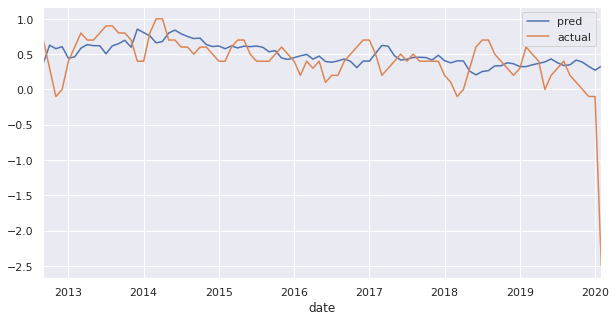

In [12]:
# check 1-month horizon plot
result_df = result_df_list[0]
result_df[["pred", "actual", "date"]].set_index("date").plot(figsize=(10,5))

### Target: Inflation

In [13]:
# estimator=LinearRegression()
estimator=Ridge()
# estimator=Lasso()
# estimator=DecisionTreeRegressor(random_state=0)

rmse_list = []
design_df_list = []
result_df_list = []
for horizon in [1,2,3,4,5,6]:
    design_df, result_df = evaluate_features(
        combined_df[tf_df.columns.tolist() + ["DATE", "CPI"]],
        date_col="DATE",
        var_col="CPI",
        horizon=horizon,
        estimator=estimator,
        window=36,
        period=1,
        return_model=True,
        start_date="2009-07-01",
        end_date="2020-03-01",
    )
    rmse = (((result_df["pred"] - result_df["actual"]) ** 2).mean()) ** 0.5
    rmse_list.append(rmse)
    design_df_list.append(design_df)
    result_df_list.append(result_df)
    print(f"Average RMSE over {len(result_df)} predictions for {horizon}-month horizon: {rmse:.3f}")

print(f"\nAverage RMSE across different horizons: {np.array(rmse_list).mean():.3f}")

Average RMSE over 90 predictions for 1-month horizon: 1.751
Average RMSE over 88 predictions for 2-month horizon: 1.917
Average RMSE over 86 predictions for 3-month horizon: 2.109
Average RMSE over 84 predictions for 4-month horizon: 2.288
Average RMSE over 82 predictions for 5-month horizon: 2.414
Average RMSE over 80 predictions for 6-month horizon: 2.579

Average RMSE across different horizons: 2.176


<AxesSubplot:xlabel='date', ylabel='CPI'>

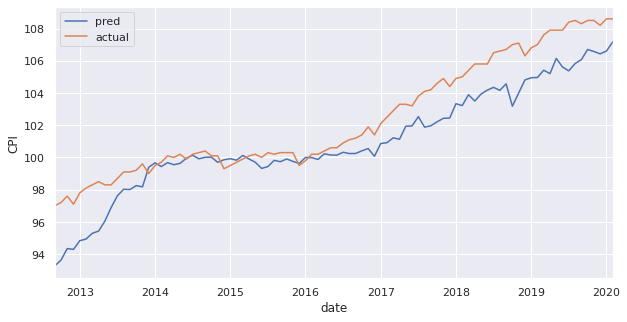

In [14]:
# check 1-month horizon plot
result_df = result_df_list[0]
result_df[["pred", "actual", "date"]].set_index("date").plot(figsize=(10,5), ylabel="CPI")

### Target: Unemployment

In [15]:
# estimator=LinearRegression()
estimator=Ridge()
# estimator=Lasso()
# estimator=DecisionTreeRegressor(random_state=0)

rmse_list = []
design_df_list = []
result_df_list = []
for horizon in [1,2,3,4,5,6]:
    design_df, result_df = evaluate_features(
        combined_df[tf_df.columns.tolist() + ["DATE", "UNEMPLOYMENT"]],
        date_col="DATE",
        var_col="UNEMPLOYMENT",
        horizon=horizon,
        estimator=estimator,
        window=36,
        period=1,
        return_model=True,
        start_date="2009-07-01",
        end_date="2020-03-01",
    )
    rmse = (((result_df["pred"] - result_df["actual"]) ** 2).mean()) ** 0.5
    rmse_list.append(rmse)
    design_df_list.append(design_df)
    result_df_list.append(result_df)
    print(f"Average RMSE over {len(result_df)} predictions for {horizon}-month horizon: {rmse:.3f}")

print(f"\nAverage RMSE across different horizons: {np.array(rmse_list).mean():.3f}")

Average RMSE over 90 predictions for 1-month horizon: 0.472
Average RMSE over 88 predictions for 2-month horizon: 0.533
Average RMSE over 86 predictions for 3-month horizon: 0.606
Average RMSE over 84 predictions for 4-month horizon: 0.665
Average RMSE over 82 predictions for 5-month horizon: 0.722
Average RMSE over 80 predictions for 6-month horizon: 0.785

Average RMSE across different horizons: 0.631
